In [1]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import system.experimental_september as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as pulse_gen
importlib.reload(pulse_gen)
import pulse.tukey_derivative as tukey_derivative
importlib.reload(tukey_derivative)
import utils.expectation_values as expect
importlib.reload(expect)
import optimization.grape as grape
importlib.reload(grape)

pass

# Optimize pulse via standard parameter gradient descent

## First, find descent starting point

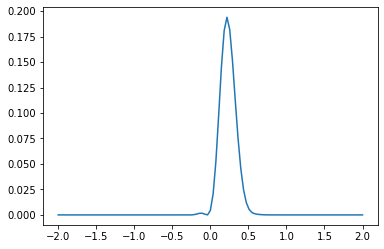

In [2]:
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm as tqdm
all_results = []
_amp = 2.5*2*np.pi
_off = 0
_dur = 20
_ramp_coef = 1

def vary_offset(off):
    tlist = np.linspace(0, _dur, int(_dur*5))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": _dur,
        "amplitude": _amp
    }

offs_to_test = np.linspace(-2, 2, 111)
offset_varying_results = parfor(vary_offset, offs_to_test)

_fids_off_sweep = []
_offs_off_sweep = []
for result in offset_varying_results:
    _fids_off_sweep.append(result["fidelity"])
    _offs_off_sweep.append(result["offset"])

plt.plot(_offs_off_sweep, _fids_off_sweep)
plt.show()
# best_offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
# offs_to_test = np.linspace(best_offset-0.01, best_offset+0.01, 50)
# offset_varying_results = parfor(vary_offset, offs_to_test)

In [3]:
offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
duration = offset_varying_results[np.argmax(_fids_off_sweep)]["duration"]
amplitude = offset_varying_results[np.argmax(_fids_off_sweep)]["amplitude"]
offset_varying_results[np.argmax(_fids_off_sweep)]

{'fidelity': 0.1939447453447449,
 'offset': 0.21818181818181825,
 'frequency': 8.099017180588968,
 'duration': 20,
 'amplitude': 15.707963267948966}

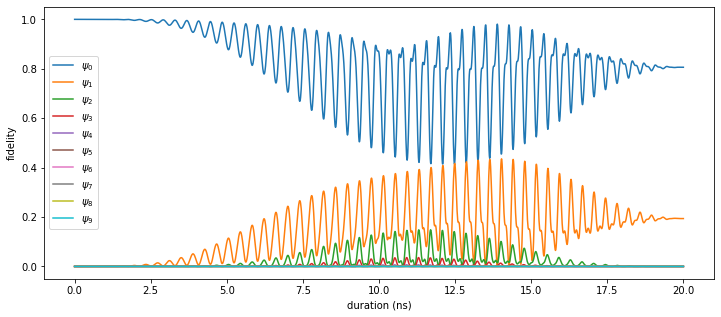

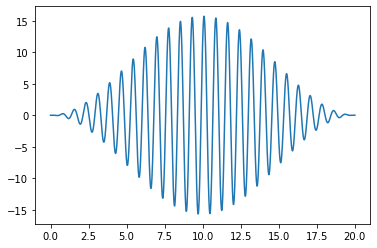

In [4]:
import utils.graph as g

tlist = np.linspace(0, duration, int(duration*100))
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
g.graph_solution(solution, system)
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
plt.show()
plt.plot(tlist, pulse_gen.get_pulse(tlist))

## Next, start optimization with given params

In [5]:
def cost_standard(parameters, constants):
    # parameters = [offset, duration]
    offset = parameters[0]
    duration = parameters[1]
    # constants = [amplitude]
    amplitude = constants[0]
    tlist = np.linspace(0, duration, int(duration*5))
    pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    return (1-fidelity)

offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
duration = offset_varying_results[np.argmax(_fids_off_sweep)]["duration"]
amplitude = offset_varying_results[np.argmax(_fids_off_sweep)]["amplitude"]
optimization_result_standard = sp.optimize.minimize(cost_standard, [offset, duration], [amplitude], method="Nelder-Mead", options={"disp":True})

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 49
         Function evaluations: 103


In [6]:
optimization_result_standard

 final_simplex: (array([[ 0.24042658, 85.24335648],
       [ 0.24042664, 85.24337679],
       [ 0.24042664, 85.24345623]]), array([5.12816402e-07, 5.12858127e-07, 5.12953627e-07]))
           fun: 5.128164021206416e-07
       message: 'Optimization terminated successfully.'
          nfev: 103
           nit: 49
        status: 0
       success: True
             x: array([ 0.24042658, 85.24335648])

In [7]:
best_standard_fidelity = (1 - optimization_result_standard.fun)

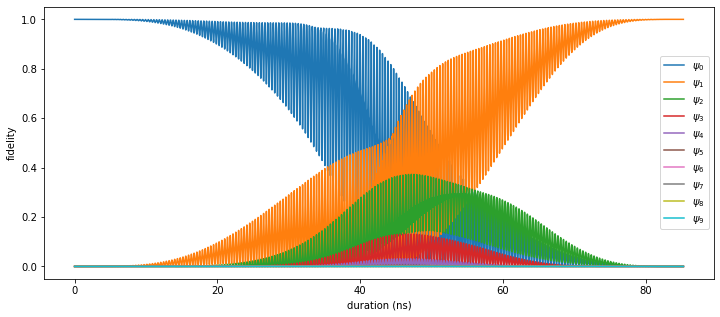

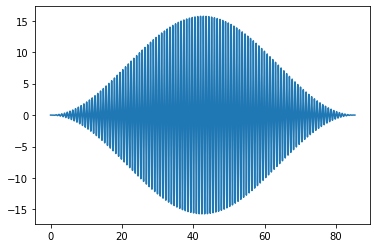

In [11]:
import utils.graph as g

tlist = np.linspace(0, optimization_result_standard.x[1], int(optimization_result_standard.x[1]*85))
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - optimization_result_standard.x[0], ramp_coef=_ramp_coef, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
g.graph_solution(solution, system)
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - optimization_result_standard.x[0], ramp_coef=_ramp_coef, tlist=tlist)
plt.show()
plt.plot(tlist, pulse_gen.get_pulse(tlist))

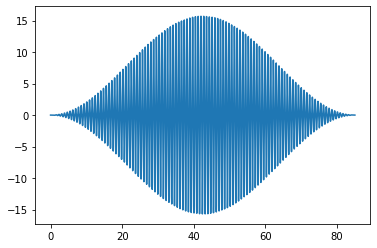

In [10]:
tlist = np.linspace(0, 85, int(85*50))
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - 0.24, ramp_coef=_ramp_coef, tlist=tlist)
plt.show()
plt.plot(tlist, pulse_gen.get_pulse(tlist))

# Add DRAG correction
Optimize drag coefficient to try to increase fidelity

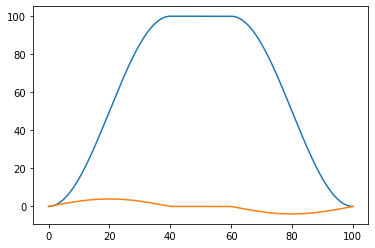

In [13]:
tlist = np.linspace(0, 100, int(100*5))
pulse_gen.setup(amplitude=100, drive_frequency= 0, ramp_coef=0.8, tlist=tlist)
tukey_derivative.setup(amplitude=100, drive_frequency= 0, ramp_coef=0.8, tlist=tlist)
plt.plot(tlist, pulse_gen.get_pulse(tlist))
plt.plot(tlist, tukey_derivative.get_pulse(tlist))
# derivative works!

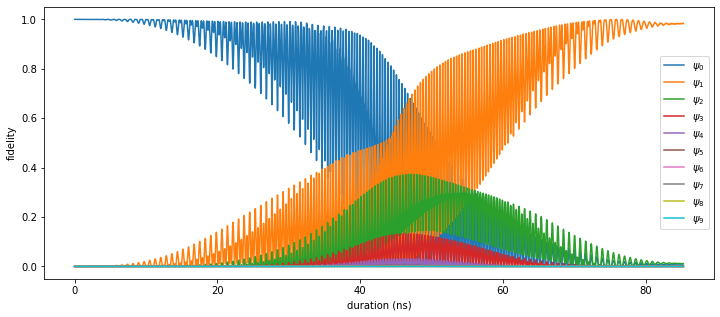

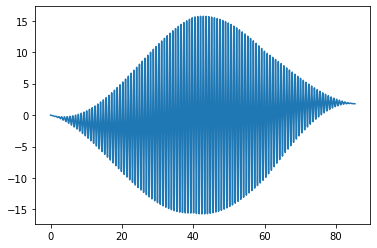

In [14]:
_drag_coef = -0.5

def pulse_with_DRAG(t, args=None):
    return pulse_gen.pulse_func(t) + _drag_coef * tukey_derivative.pulse_func(t)

tlist = np.linspace(0, optimization_result_standard.x[1], int(optimization_result_standard.x[1]*85))
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - optimization_result_standard.x[0], ramp_coef=_ramp_coef, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_with_DRAG, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
g.graph_solution(solution, system)
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - optimization_result_standard.x[0], ramp_coef=_ramp_coef, tlist=tlist)
plt.show()
plt.plot(tlist, np.vectorize(pulse_with_DRAG)(tlist))

In [67]:
def cost_drag(parameters, constants):
    global _drag_coef
    _drag_coef = parameters[0]
    offset = constants[0]
    duration = constants[1]
    amplitude = constants[2]
    tlist = np.linspace(0, duration, int(duration*5))
    pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    tukey_derivative.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_with_DRAG, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    print(fidelity)
    return (1-fidelity)

constants = optimization_result_standard.x
constants = np.append(constants, 2.5*2*np.pi)
optimization_result_drag = sp.optimize.minimize(cost_drag, [-0.5], constants, method="Nelder-Mead", options={"disp":True})

0.9999798231789858
0.9999756144969394
0.9999834559964352
0.9999865566048104
0.999991391549983
0.9999947185943583
0.9999982204221685
0.9999993089179422
0.9999994860926493
0.9999983367208224
0.9999983367208224
0.9999994823141786
0.9999993457885159
0.9999994871835884
0.9999994823141786
0.9999994850443965
0.9999994850443965
0.9999994842977699
0.99999948538989
0.9999994819826302
0.9999994849392486
0.9999994849392486
0.9999994856834459
0.9999994864411599
0.9999994858665102
0.9999994843395938
0.9999994843395938
0.9999994883387717
0.9999994858665102
0.9999994858665102
0.9999994836367849
0.9999994836367849
0.9999994857471134
0.9999994858287997
0.9999994875011031
0.9999994855714252
0.9999994827894282
0.9999994855714252
0.9999994825442607
0.9999994861280581
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 17
         Function evaluations: 40


In [68]:
_drag_coef = optimization_result_drag.x[0]
optimization_result_drag

 final_simplex: (array([[0.0015625 ],
       [0.00166016]]), array([5.11661228e-07, 5.13871942e-07]))
           fun: 5.116612282751731e-07
       message: 'Optimization terminated successfully.'
          nfev: 40
           nit: 17
        status: 0
       success: True
             x: array([0.0015625])

In [92]:
best_drag_fidelity = 1 - optimization_result_drag.fun
print("best_drag_fidelity ", best_drag_fidelity)
print("best_standard_fidelity ", best_standard_fidelity)
print("improvement due to drag", best_drag_fidelity - best_standard_fidelity)

best_drag_fidelity  0.9999994883387717
best_standard_fidelity  0.9999994871835979
improvement due to drag 1.1551738454684823e-09


# Start GRAPE with best DRAG curve

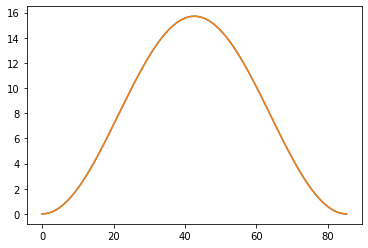

In [87]:
offset = constants[0]
duration = constants[1]
amplitude = constants[2]
tlist = np.linspace(0, duration, 10000)
# system.first_energy_spacing/3 - offset
pulse_gen.setup(amplitude, drive_frequency= 0 , ramp_coef=_ramp_coef, tlist=tlist)
tukey_derivative.setup(amplitude, drive_frequency= 0 , ramp_coef=_ramp_coef, tlist=tlist)
best_drag_pulse = pulse_gen.get_pulse(tlist) + _drag_coef * tukey_derivative.get_pulse(tlist)
plt.plot(tlist, best_drag_pulse)
bin_size = 1
smoothing_time = 5
binned_tlist = np.linspace(0, tlist[-1], int(tlist[-1]/bin_size))
binned_best_drag_pulse = pulse_gen.get_pulse(binned_tlist) + _drag_coef * tukey_derivative.get_pulse(binned_tlist)
plt.plot(binned_tlist, binned_best_drag_pulse)

In [88]:
grape.setup(system, binned_best_drag_pulse, offset, duration, bin_size, smoothing_time)

[ 0.          1.0132272   2.02645439  3.03968159  4.05290879  5.06613598
  6.07936318  7.09259038  8.10581757  9.11904477 10.13227197 11.14549916
 12.15872636 13.17195356 14.18518075 15.19840795 16.21163515 17.22486234
 18.23808954 19.25131674 20.26454393 21.27777113 22.29099832 23.30422552
 24.31745272 25.33067991 26.34390711 27.35713431 28.3703615  29.3835887
 30.3968159  31.41004309 32.42327029 33.43649749 34.44972468 35.46295188
 36.47617908 37.48940627 38.50263347 39.51586067 40.52908786 41.54231506
 42.55554226 43.56876945 44.58199665 45.59522385 46.60845104 47.62167824
 48.63490544 49.64813263 50.66135983 51.67458703 52.68781422 53.70104142
 54.71426862 55.72749581 56.74072301 57.75395021 58.7671774  59.7804046
 60.7936318  61.80685899 62.82008619 63.83331338 64.84654058 65.85976778
 66.87299497 67.88622217 68.89944937 69.91267656 70.92590376 71.93913096
 72.95235815 73.96558535 74.97881255 75.99203974 77.00526694 78.01849414
 79.03172133 80.04494853 81.05817573 82.07140292 83.0

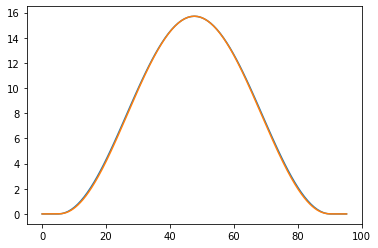

In [89]:
print(grape.config.time)
print(pulse)
print(grape.config.original_pulse)
print(grape.config.padding_t_slots)
print(len(grape.config.original_pulse))
plt.plot(grape.config.time, grape.config.original_pulse)
plt.plot(grape.config.smoothed_time, grape.config.original_pulse_smoothed)

In [90]:
solution = grape.single_run()

best_drag_fidelity 0.9999994883387717
starting grape fidelity  0.9997869626371003
difference  -0.0002125257016714066
Fidelity = 0.999787, Offset = 0.240427


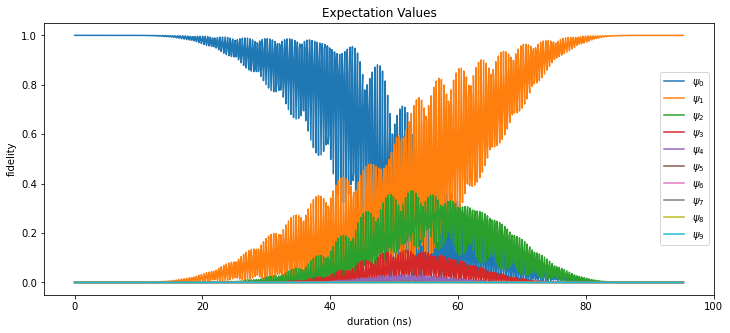

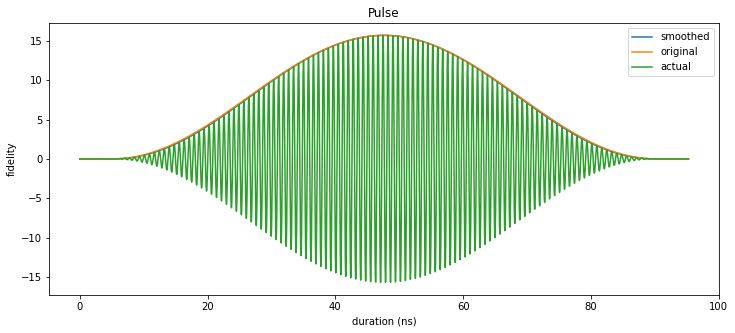

In [95]:
print("best_drag_fidelity", best_drag_fidelity)
expectation_values = expect.get_all_expectation_values(grape.config.last_solution.states, system.basis_states)
print("starting grape fidelity ", expectation_values[1][-1])
print("difference ", expectation_values[1][-1] - best_drag_fidelity)

grape.graph_last_solution()

In [96]:
# THIS TAKES TOO LONG AND WE LOSE PRECISION OF WAVE PULSE USING GRAPE

final_result = grape.optimize()

1 : 0.999787
2 : 0.999787
3 : 0.999786


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

Fidelity = 0.995064, Offset = 0.364773


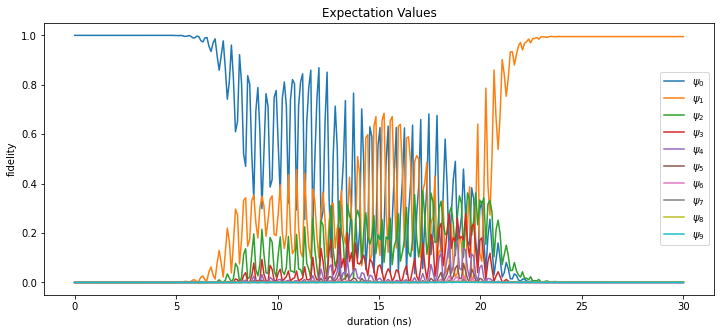

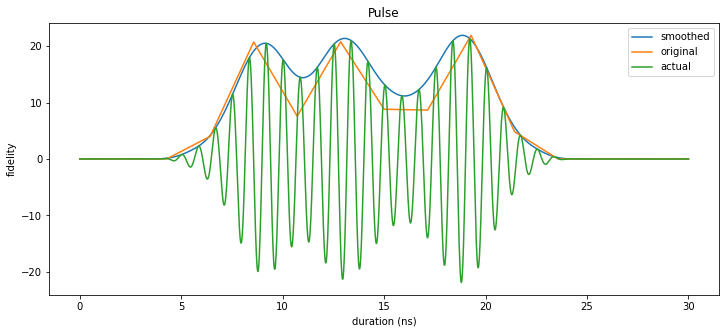

In [ ]:
grape.graph_last_solution()